In [11]:
"""
CVaR.py>
"""
import numpy as np
import math
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
from numpy import linalg
from scipy.stats import gmean
from scipy.optimize import linprog
from scipy.stats import norm
from scipy import stats

# ----- function: CVaR model ------
"""
min     gamma + (1 / [(1 - alpha) * S]) * sum( z_s )
s.t.    z_s   >= 0,                 for s = 1, ..., S
        z_s   >= -r_s' x - gamma,   for s = 1, ..., S
        1' x  =  1,
        mu' x >= R
"""

def CVaR(returns, alpha):
    mu = gmean(returns+1) - 1  # Estimate the geometric mean
    R = 1.1 * np.mean(mu)  # Set our target return
    t, p = returns.shape  # Determine the number of assets and scenarios
    # formulate the linear program
    # bound
    lst_t = np.ones(t)
    lst_p = np.ones(p)
    bounds = tuple((0, None) for i in lst_p) + tuple((0, None) for i in lst_t) + \
             tuple((-math.inf, None) for i in np.ones(1))
    # inequality constraint matrix A and vector b
    A = np.vstack((np.hstack((-returns, -np.identity(t), -np.ones((t, 1)))),
                  np.hstack((-mu[np.newaxis], np.zeros((1, t)), np.zeros((1, 1))))))
    b = np.vstack((np.zeros((t, 1)), -R[np.newaxis]))
    # equality constraint matrix Aeq and vector beq
    Aeq = np.hstack((np.ones((1, p)), np.zeros((1, t)), np.zeros((1, 1))))
    beq = 1
    # coefficient of variables
    k = 1 / ((1 - alpha) * t)
    c = np.vstack((np.zeros((p, 1)), k*np.ones((t, 1)), np.ones((1, 1))))
    # linprog optimizer
    res = linprog(c, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds)
    x = np.asmatrix(res.x[:p])

    return x

In [12]:
"""
OLS.py>
"""

import numpy as np
from numpy.linalg import inv

# ----- function: OLS regression model ------
def OLS(returns, factRet):
    t, p = factRet.shape  # Number of observations and factors
    factRet = factRet.to_numpy(dtype=np.float64)
    returns = returns.to_numpy()
    X = np.hstack((np.ones((t, 1), dtype=np.float64), factRet))  # factor matrix;
    B = np.dot(np.dot(inv(np.dot(X.T, X)), X.T), returns)  # Regression coefficients;
    # separate B into alpha and betas
    a = B[0, :]
    V = B[1:, :]

    # residual variance
    ep = returns - np.dot(X, B)
    ep_2_sum = np.sum(ep ** 2, axis=0)  # sum each matrix column
    sigma_ep = 1 / (t - p - 1) * ep_2_sum
    D = np.diag(sigma_ep)

    # factor expected returns and covariance matrix
    f_bar = np.mean(factRet, axis=0)
    F = np.cov(factRet, rowvar=False)

    # Calc. asset expected returns and covariance matrices
    mu = a + np.dot(V.T, f_bar)
    Q = np.dot(np.dot(V.T, F), V) + D
    Q = (Q + Q.T) / 2

    # calc. adjusted R-squared
    r_bar = np.mean(returns, axis=0)
    RSS = ep_2_sum
    TSS = np.sum((returns - r_bar) ** 2, axis=0)
    R2 = 1 - RSS / TSS
    adj_R2 = 1 - (1 - R2) * ((t - 1) / (t - p - 1))
    adj_R2_bar = np.mean(adj_R2)

    return mu, Q, adj_R2_bar

In [13]:
"""
RP.py>
"""

import numpy as np
from scipy.optimize import minimize

# ----- function: Risk Parity model ------

# risk budgeting optimization
def calculate_portfolio_var(x, Q):
    # function that calculates portfolio risk
    x = np.matrix(x)
    return (x * (Q * x.T))[0, 0]

def calculate_risk_contribution(x, Q):
    # function that calculates asset contribution to total risk
    x = np.matrix(x)
    sigma = np.sqrt(calculate_portfolio_var(x, Q))
    # Marginal Risk Contribution
    MRC = Q * x.T
    # Risk Contribution
    RC = np.multiply(MRC, x.T)/sigma
    return RC

def risk_budget_objective(x, pars):
    # calculate portfolio risk
    Q = pars[0]  # covariance table
    x_targ = pars[1]  # risk target in percent of portfolio risk
    sig_p = np.sqrt(calculate_portfolio_var(x, Q))  # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p, x_targ))
    asset_RC = calculate_risk_contribution(x, Q)
    J = sum(np.square(asset_RC-risk_target.T))[0, 0]  # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

def RP(Q):
    p = Q.shape[0]  # number of assets
    tol = 1e-14
    x_targ = np.full(p, 1 / p)  # define initial portfolio (equal risk)
    x0 = np.random.dirichlet(np.ones(p), size=1)
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
            {'type': 'ineq', 'fun': long_only_constraint})
    res = minimize(risk_budget_objective, x0=x0, args=[Q, x_targ], method='SLSQP', constraints=cons,
                   tol=tol, options={'disp': False, 'maxiter': 10000})
    x = np.asmatrix(res.x)
    return x

In [14]:
"""
robustMVO.py>
"""

import numpy as np
import math
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
from numpy import linalg

# ----- function: robust MVO model ------

# model:
# min. lambda * (x' * Q * x) - mu' x + epsilon * norm (sqrtTh * x)
# s.t.  sum(x) == 1
#            x >= 0

def total_weight_constraint(x):
    return np.sum(x)-1.0

'''
def long_only_constraint(x):
    return x
'''

def sqrt_theta(Q, alpha):
    p = Q.shape[0]  # find the number of assets
    ep = math.sqrt(chi2.ppf(alpha, df=p))  # Define the radius of the uncertainty set
    theta = np.diag(np.diag(Q)) / p  # find the squared standard error of our expected returns
    sqrtTh = np.sqrt(theta)  # square root of theta
    return sqrtTh, ep

def objFn(x, pars):
    mu = pars[0]
    Q = pars[1]
    riskAver = pars[2]
    sqrtTh = pars[3]
    ep = pars[4]
    # objective function
    f = riskAver * np.dot(np.dot(x, Q), x.T) - np.dot(mu.T[np.newaxis], x.T) + ep * linalg.norm(sqrtTh * x)
    return f

def robustMVO(mu, Q, riskAver, alpha):
    p = Q.shape[0]  # find the number of assets
    sqrtTh, ep = sqrt_theta(Q, alpha)
    x0 = np.random.dirichlet(np.ones(p), size=1)[0] # initial weight
    tol = 1e-14
    cons = ({'type': 'eq', 'fun': total_weight_constraint})
    lst = np.ones(p)
    bounds = tuple((0, 1) for i in lst)
    res = minimize(objFn, x0=x0, args=[mu, Q, riskAver, sqrtTh, ep], method='SLSQP', constraints=cons,
                   bounds=bounds, tol=tol, options={'disp': False, 'maxiter': 10000})
    x = np.asmatrix(res.x)
    return x

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from openpyxl import load_workbook
import math
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from copulas.multivariate import VineCopula
import statsmodels.api as sm
pd.set_option('display.max_columns', 20)

In [16]:
# ================== Robo Advisor <All Weather Global Portfolio> ==============================
dir = os.getcwd()  # wd

# 1. Link to the Robo Advisor UI and get user inputs
wb = load_workbook(dir + r'\AWGP_RoboAdvisor.xlsx')
ws = wb['UI']
name = ws[list(wb.defined_names['name'].destinations)[0][1]].value
age = ws[list(wb.defined_names['age'].destinations)[0][1]].value
cap = ws[list(wb.defined_names['cap'].destinations)[0][1]].value
startDate = ws[list(wb.defined_names['startDate'].destinations)[0][1]].value
injection = ws[list(wb.defined_names['injection'].destinations)[0][1]].value
injectFreq = ws[list(wb.defined_names['injectFreq'].destinations)[0][1]].value
ESG = ws[list(wb.defined_names['ESG'].destinations)[0][1]].value
ESGperc = ws[list(wb.defined_names['ESGperc'].destinations)[0][1]].value
caliYr = ws[list(wb.defined_names['caliYr'].destinations)[0][1]].value
leverage = ws[list(wb.defined_names['leverage'].destinations)[0][1]].value
reportDate = ws[list(wb.defined_names['reportDate'].destinations)[0][1]].value
rebalFreq = ws[list(wb.defined_names['rebalFreq'].destinations)[0][1]].value  # rebalancing frequency is every 6 months
cost = ws[list(wb.defined_names['cost'].destinations)[0][1]].value  # transaction cost per unit of ETF traded
countryPerc = ws[list(wb.defined_names['countryPerc'].destinations)[0][1]].value
equityFI_perc = ws[list(wb.defined_names['equityFI_perc'].destinations)[0][1]].value
alpha = ws[list(wb.defined_names['alpha'].destinations)[0][1]].value  # confidence level
riskAver = ws[list(wb.defined_names['riskAver'].destinations)[0][1]].value  # risk tolerance

# 2. Link to the investment pool (ESG + non_ESG ETFs) and factors
# data is from 2007/01/01

# ETFs
df_ESG = pd.read_excel(dir + r'\ESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = pd.read_excel(dir + r'\NonESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = df_nonESG.loc[:, ~df_nonESG.columns.str.contains('^Unnamed')]
ret_ESG = df_ESG.pct_change().iloc[1:].loc[:reportDate]
ret_nonESG = df_nonESG.pct_change().iloc[1:].loc[:reportDate]

# select ETFs with low correlations
def select_ETF(df1, df2, threshold):
    df = df1.copy()
    cor = df.corr().abs()
    # Select upper/lower triangle of correlation matrix
    upper_triangle = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
    # Find features with correlation greater than threshold
    drop_lst1 = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print('number of features dropped that have high correlations: ' + str(len(drop_lst1)))
    # Drop features
    df2.drop(drop_lst1, axis=1, inplace=True)
    print('number of features left: ' + str(len(df2.columns)))
    return df2

ret_ESG = select_ETF(ret_ESG.loc[:startDate], ret_ESG, 0.8)
ret_nonESG = select_ETF(ret_nonESG.loc[:startDate], ret_nonESG, 0.8)

# dates and tickers
dates = ret_ESG.index
tickers_nonESG = list(ret_nonESG.columns)
tickers_ESG = list(ret_ESG.columns)
df_ESG = pd.DataFrame(df_ESG, columns=tickers_ESG)
df_nonESG = pd.DataFrame(df_nonESG, columns=tickers_nonESG)
print("nonESG ETFs left:" + str(tickers_nonESG))
print("ESG ETFs left:" + str(tickers_ESG))


# sensitivity analysis. handling df_macro
df_macro = pd.read_excel(dir + r'\Macro_Data.xlsx', sheet_name='Index', index_col=0, engine='openpyxl')
df_macro = df_macro.drop(['AAA', 'BAA'], axis=1)
df_macro['USACPIALLMINMEI'] = df_macro['USACPIALLMINMEI'].pct_change() * 100
df_macro['INDPRO'] = df_macro['INDPRO'].pct_change() * 100
df_macro[['MCOILWTICO', 'HOUST']] = df_macro[['MCOILWTICO', 'HOUST']].pct_change() * 100
# PCA the yield curve
yieldcurve = df_macro[['GS30', 'GS20', 'GS10', 'GS5', 'GS3', 'GS1', 'GS3M']]
yieldcurve = StandardScaler().fit_transform(yieldcurve)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(yieldcurve)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component'])
df_macro['Yield Curve PCA'] = principalDf.values
df_macro = df_macro.drop(['GS30', 'GS20', 'GS10', 'GS5', 'GS3', 'GS1', 'GS3M'], axis=1)
df_macro=df_macro.iloc[1:]

df_macro = select_ETF(df_macro.loc[:startDate],df_macro,0.6)
tickers_macro = list(df_macro.columns)
print("Macro Factor left:" + str(tickers_macro))

# ----- input: final selected ETFs - need to update the list manually according to the above print output ------
allocation_model = 'RP'
tickers_nonESG_equity_FI_USD = ['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'SHY', 'TLT', 'TIP', 'LQD', 'MHWIX']
tickers_nonESG_other_USD = ['IYR', 'GLD', 'GSG']
tickers_nonESG_equity_FI_CAD = ['XIT.TO', 'XBB.TO', 'XRB.TO']
tickers_nonESG_other_CAD = ['XRE.TO']
tickers_ESG_equity_USD = ['XLB', 'SOXX']
# --------------------------------------------------------------------------------------------------------------


number of features dropped that have high correlations: 2
number of features left: 2
number of features dropped that have high correlations: 19
number of features left: 17
nonESG ETFs left:['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'XIT.TO', 'SHY', 'TLT', 'TIP', 'LQD', 'XBB.TO', 'XRB.TO', 'IYR', 'XRE.TO', 'GLD', 'MHWIX', 'GSG']
ESG ETFs left:['XLB', 'SOXX']
number of features dropped that have high correlations: 2
number of features left: 6
Macro Factor left:['INDPRO', 'USACPIALLMINMEI', 'CBS', 'T10Y3MM', 'HOUST', 'Yield Curve PCA']


In [17]:
# factors
factors = pd.read_csv(dir + r'\FF_5_Factor.csv', index_col=0)
rf = pd.DataFrame(factors['RF'].iloc[1:], columns=['RF'])
ret_factor = factors.drop('RF', axis=1).iloc[1:]
rf.set_index(dates, inplace=True)
ret_factor.set_index(dates, inplace=True)

# CAD/USD FX rate
FX = pd.read_csv(dir + r'\USD_CAD_Historical_Data.csv', index_col=0)
FX.set_index(dates, inplace=True)

# Excess Return
exRet_nonESG = ret_nonESG.sub(rf['RF'], 0)
exRet_ESG = ret_ESG.sub(rf['RF'], 0)

# leverage
init_cap = cap * (1+leverage)  # total initial capital including leverage
loan = cap * leverage  # loan at start of investment period; interest rate = RFR

# 3. system implementation
exRet_portf = exRet_nonESG.copy()  # portfolio excess return dataset
# separate by asset class
exRet_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_USD)
exRet_other_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_USD)
exRet_equity_FI_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_CAD)
exRet_other_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_CAD)
# apply FX on USD ETFs
if ESG == 'No':
    price_portf = df_nonESG.iloc[1:].loc[:reportDate].copy()  # investment portfolio's monthly price dataset
    # apply FX on USD ETFs
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD].mul(FX['Price'], axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                             price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD]],
                            axis=1).copy()
if ESG == 'Yes':
    price_portf = pd.concat([df_nonESG, df_ESG], axis=1).iloc[1:].loc[:reportDate].copy()
    exRet_portf = pd.concat([exRet_nonESG, exRet_ESG], axis=1).copy()
    # ESG ETFs returns
    exRet_ESG_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_ESG_equity_USD)
    # apply FX on USD ETFs
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD].mul(FX['Price'],
                                                                                                          axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                         price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD],
                         price_portf[tickers_ESG_equity_USD]],
                        axis=1).copy()


n = exRet_portf.shape[1]  # number of ETFs in the portfolio
n_equity_FI_USD = exRet_equity_FI_USD.shape[1]  # number of USD ETFs (equity+FI)
n_other_USD = exRet_other_USD.shape[1]  # number of USD ETFs (equity+FI)
n_equity_FI_CAD = exRet_equity_FI_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_other_CAD = exRet_other_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.shape[1]  # number of ESG USD ETFs (equity+FI)
testStart = exRet_portf.loc[startDate:].index[0]  # each rebalancing period start date
testEnd = exRet_portf.loc[startDate:].index[6] - timedelta(days=1)   # each rebalancing period end date
caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
NoPeriods = math.ceil((len(exRet_portf.loc[startDate:]) - 1) / rebalFreq)  # number of rebalancing periods
testMonths = len(exRet_portf.loc[startDate:])
testDate = exRet_portf.loc[startDate:].index
testDate2 = np.zeros(NoPeriods, dtype='datetime64[ns]')

# Preallocate space
x_equity_FI_USD = np.zeros((n_equity_FI_USD, NoPeriods))
x_other_USD = np.zeros((n_other_USD, NoPeriods))
x_equity_FI_CAD = np.zeros((n_equity_FI_CAD, NoPeriods))
x_other_CAD = np.zeros((n_other_CAD, NoPeriods))
x_ESG_equity_FI_USD = np.zeros((n_ESG_equity_FI_USD, NoPeriods))
x = np.zeros((n, NoPeriods))
x0 = np.zeros((n, NoPeriods))
adj_R2_bar = np.zeros(NoPeriods)
NoShares = np.zeros(n)
NoShares_new = np.zeros(n)
currentVal = np.zeros(NoPeriods)
portfValue = np.zeros(testMonths)
turnover = np.zeros(NoPeriods)
interest = 0

# loop through each rebalancing period
for t in range(NoPeriods):
    # excess return of portfolio for the calibration period
    ret_cali_equity_FI_USD = exRet_equity_FI_USD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_USD = exRet_other_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    ret_cali_equity_FI_CAD = exRet_equity_FI_CAD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_CAD = exRet_other_CAD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    if ESG == 'Yes':
        ret_cali_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]

    # factors return for the calibration period
    ret_factor_cali = ret_factor.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    currPrice = price_portf.loc[:caliEnd].iloc[-1]  # last observed price during calibration period
    testPrice = price_portf.loc[testStart:testEnd]  # rebalancing period prices
    testPeriod = len(price_portf.loc[testStart:testEnd])
    testDate2[t] = price_portf.loc[testStart:testEnd].index[-1].value

    if t == 0:
        currentVal[t] = init_cap
    else:
        currentVal[t] = np.dot(currPrice, NoShares) + injection - trans_cost

        # store the current asset weights (before rebalance)
        x0[:, t] = (currPrice * NoShares) / currentVal[t]

    # portfolio construction
    # factor model: OLS calibration + optimization model: Risk Parity, apply on each class
    if allocation_model == 'RP':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1-equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1-equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = RP(Q5) * ESGperc  # 20%

    elif allocation_model == 'CVaR':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = CVaR(ret_cali_ESG_equity_FI_USD, alpha) * ESGperc  # 20%

    elif allocation_model == 'robustMVO':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * (countryPerc * equityFI_perc - ESGperc)

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = robustMVO(mu5, Q5, riskAver, alpha) * ESGperc
    # adjusted R-square: check model fitting
    if ESG == 'No':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4) / 4
        x[:, t] = np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]), x_equity_FI_CAD[:, t]),
                            x_other_CAD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD
        weights = pd.DataFrame(x.T, columns=tickers)
    elif ESG == 'Yes':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4 + adj_R2_bar5) / 5
        x[:, t] = np.append(np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]),
                                                x_equity_FI_CAD[:, t]), x_other_CAD[:, t]), x_ESG_equity_FI_USD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD + tickers_ESG_equity_USD
        weights = pd.DataFrame(x.T, columns=tickers)

    NoShares_new = x[:, t] * currentVal[t] / currPrice  # Number of shares to be allocated to each ETFs
    trans_cost = sum(abs(NoShares_new - NoShares) * cost)
    NoShares = NoShares_new
    

    for j in range(testPeriod):
        index_portf = np.where(exRet_portf.loc[startDate:].index == testStart)[0][0]
        # loan interest accumulation
        rf_7yr = 1.56  # used 7-year treasury rate from 2016-04-01 which is 1.56%
        loan_pay = loan * (1 + rf_7yr / 100) ** ((index_portf+j)/12)  # accumulated by 7-year treasury rate

        if j == 0:
            price_portf.loc[testStart]
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay - trans_cost
        else:
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay

    # calculate the turnover rate
    if t > 0:
        turnover[t] = sum(abs(x[:, t] - x0[:, t]))

    # Update the calibration and out-of-sample test periods
    if t < 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[6] - timedelta(days=1)  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
    elif t == 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[-1]  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period


# outputs:
print('portfolio value evolution:' + str(portfValue.T))
print(weights)  # portfolio weighting
# print('portfolio weighting:' + str(x.T))
print('turnover:' + str(turnover))
print('adjusted R-squared:' + str(adj_R2_bar))
print('date:' + str(testDate))

portfolio value evolution:[ 98520.85392687  98109.13698816 101955.61549996 104339.38628839
 104665.6819564  105535.72208996 113876.76962373 115553.96024948
 116132.71618711 117764.6904969  117568.556352   119755.21819755
 131365.56982495 135189.90989127 132212.09570081 129716.05527871
 128911.26130617 129351.17383401 143029.04223099 147095.03750682
 147423.20236254 148181.48223747 144959.71205818 148059.30222058
 157542.39590797 161448.89089078 161905.59936788 163890.15526022
 164969.69238884 163331.800556   166086.44985462 169873.97080423
 167011.97723389 177650.29580942 177541.87883977 182388.08182497
 197293.03554855 193851.62690055 202126.35958655 201187.65697593
 204972.31258251 206218.93814344 217099.17058162 219898.22944183
 221982.79500463 222558.93744195 219236.80348858 198151.3788653
 231512.964992   238005.02223881 242948.62713384 251725.6432061
 251774.57644074 246187.96497645 256118.51345534 274675.40521942
 273645.06630953 270362.81414412 273220.5109664  276242.78013797
 

In [18]:
# sensitivity analysis for the allocation model
portfRet_up=np.zeros((len(df_macro.columns),len(df_macro.columns)+2))
portfRet_down=np.zeros((len(df_macro.columns),len(df_macro.columns)+2))
df_portfValue = pd.DataFrame(portfValue,index=testDate,columns=['portfValue'])
df_portfRet = df_portfValue.pct_change().dropna()

# macro data for the test period
df_macro_test = df_macro.loc[df_portfRet.index]
# fit model for x=macro data, y=portofolio value during the test period
df_macro_test = sm.add_constant(df_macro_test)
model = sm.OLS(df_portfRet, df_macro_test).fit()
macro_coef = model.params

norm_scenario = df_macro_test.median()
portfRet_norm = np.dot(np.array(norm_scenario), np.array(model.params))
print('For the normal scenario, the monthly portfolio return is {}'.format(portfRet_norm))
# up scenario for each macro factor
for i in range(norm_scenario.shape[0]):
    if i != 0:
        norm_scenario_up = norm_scenario.copy()
        macro_fact = norm_scenario_up.index[i]
        norm_scenario_up[macro_fact]=norm_scenario_up[macro_fact]*2
        portfRet_up[i-1,:-1] = norm_scenario_up
        portfRet_up[i-1,-1] = np.dot(np.array(norm_scenario_up), np.array(model.params))
portfRet_up_df = pd.DataFrame(portfRet_up,columns = norm_scenario.index.to_list() + ['Monthly Return'])
# down scenario for each macro factor
for i in range(norm_scenario.shape[0]):
    if i != 0:
        norm_scenario_down = norm_scenario.copy()
        macro_fact = norm_scenario_down.index[i]
        norm_scenario_down[macro_fact]=norm_scenario_down[macro_fact]*0.5
        portfRet_down[i-1,:-1] = norm_scenario_down
        portfRet_down[i-1,-1] = np.dot(np.array(norm_scenario_down), np.array(model.params))
portfRet_down_df = pd.DataFrame(portfRet_down,columns = norm_scenario.index.to_list() + ['Monthly Return'])

copula = VineCopula('center')
copula.fit(df_macro_test.drop(['const'],axis=1))
samples = copula.sample(1000)
samples.insert(0, 'constant', 1)
samplePortfolio = np.dot(np.array(samples), np.array(model.params))
samples['Portfolio Estimated Return'] = samplePortfolio
upScenario1 = samples.sort_values('Portfolio Estimated Return', ascending=0).iloc[:3, :]
downScenario1 = samples.sort_values('Portfolio Estimated Return', ascending=1).iloc[:3, :]
print('the best 3 up scenario: {}'.format(upScenario1))
print('the best 3 down scenario: {}'.format(downScenario1))

For the normal scenario, the monthly portfolio return is 0.019342163437892346


C:\Users\lenovo-pc\AppData\Roaming\Python\Python38\site-packages\copulas\multivariate\vine.py:68: UserWarning: Vines have not been fully tested on Python 3.8 and might produce wrong results. Please use Python 3.5, 3.6 or 3.7
  warnings.warn(


the best 3 up scenario:      constant     INDPRO  USACPIALLMINMEI       CBS   T10Y3MM      HOUST  \
675         1 -12.133429         0.088175  0.786063  0.627156  13.499781   
874         1 -13.772780         0.067066  0.764348  0.488202   4.754507   
552         1   0.064273         0.802476  1.674159  2.051743  13.110195   

     Yield Curve PCA  Portfolio Estimated Return  
675        -0.585688                    0.120628  
874         0.561959                    0.118666  
552         2.150470                    0.095035  
the best 3 down scenario:      constant    INDPRO  USACPIALLMINMEI       CBS   T10Y3MM     HOUST  \
162         1  5.965902        -0.336465  0.585836 -0.307639  1.596970   
871         1  1.568154        -0.459706  0.541753 -0.468884 -6.909413   
731         1  4.587063        -0.007270  0.783652  0.540676 -2.916406   

     Yield Curve PCA  Portfolio Estimated Return  
162        -2.399120                   -0.059925  
871        -0.891415                   -0.

In [19]:
def VaRCalc(returns):
    #VaR and CVaR Calculation
    
    period = 1. # horizon of 1 day
    mu_p = np.mean(returns)/30
    sig_p = np.std(returns)*np.sqrt(period/30)
    alpha = 0.01

    VaR = norm.ppf(1-alpha)*sig_p - mu_p 
    value=portfValue[-1]*VaR
    print("99% 1 day VaR :", round(VaR*100,2),"% or", round(value),"$")

    CVaR = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_p - mu_p
    value=portfValue[-1]*CVaR
    print("99% 1 day CVaR/ES :", round(CVaR*100,2),"% or", round(value),"$")

    period = 10. # horizon of 10 days
    mu_p = np.mean(returns)/30*period
    sig_p = np.std(returns) * np.sqrt(period/30)
    VaR = norm.ppf(1-alpha)*sig_p - mu_p
    value=portfValue[-1]*VaR
    print("99% 10 day VaR :", round(VaR*100,2),"% or", round(value),"$")

    CVaR = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_p - mu_p
    value=portfValue[-1]*CVaR
    print("99% 10 day CVaR/ES :", round(CVaR*100,2),"% or", round(value),"$")

In [20]:
# Scenario Analysis - Stress VaR
# factors
factors_all = pd.read_csv(dir + r'\FF_5_Factor_all.csv', index_col=0,parse_dates=True)
ret_factor_all = factors_all[['Mkt-RF','SMB','HML','RMW','CMA']].iloc[:-1,:]
ret_factor_test = ret_factor_all.loc[testDate]

data_all = pd.read_excel(dir + r'\Historical_Data.xlsx', sheet_name='Sheet1', index_col=0,engine='openpyxl')
data_all = data_all.pct_change()

# fit model. X=famma french 5 factors, y=asset return
scenario_coef = np.zeros((len(ret_factor_all.columns)+1,len(exRet_portf.columns)))
exRet_portf_test = exRet_portf.loc[ret_factor_test.index] # may change a bit
ret_factor_test = sm.add_constant(ret_factor_test)

for tickerindex in range(len(exRet_portf_test.columns)):
    ticker = exRet_portf_test.columns[tickerindex]
    scenario_model = sm.OLS(exRet_portf_test[ticker], ret_factor_test).fit()
    scenario_coef[:,tickerindex] = scenario_model.params
scenario_coef = pd.DataFrame(scenario_coef,columns = exRet_portf.columns) 
scenario_coef.index = ['const'] + list(ret_factor_all.columns)

ret_factor_all = sm.add_constant(ret_factor_all)
regressed = np.dot(ret_factor_all,scenario_coef)
regressed = pd.DataFrame(regressed,columns = exRet_portf.columns)
regressed.index = ret_factor_all.index # simulated past asset return

for i in range(data_all.shape[0]): #iterate over rows
    for j in range(data_all.shape[1]): #iterate over columns
        adate = data_all.index[i]
        aticker = data_all.columns[j]
        if pd.isna(data_all.iloc[i, j]):
            data_all.iloc[i, j] = regressed.loc[adate,aticker]

# list of historical scenarios
# using the weights during the initial test period

# all historical data are simulated so it's not very reliable. skip it
# factors_AsianCrisis = ret_factor_all.loc['1998-04-01':'1998-10-01']
# AsianCrisis = np.dot(np.dot(factors_AsianCrisis,scenario_coef),weights.iloc[0])
# print('For {}:'.format('AsianCrisis'))
# VaRCalc(AsianCrisis)

techBubble = np.dot(data_all.loc['2000-03-01':'2002-09-01'],weights.iloc[0])
print('For {}:'.format('techBubble'))
VaRCalc(techBubble)

sellOff911 = np.dot(data_all.loc['2001-07-01':'2001-09-01'],weights.iloc[0])
print('For {}:'.format('sellOff911'))
VaRCalc(sellOff911)

subprimeRecession = np.dot(data_all.loc['2008-01-01':'2009-06-01'],weights.iloc[0])
print('For {}:'.format('subprimeRecession'))
VaRCalc(subprimeRecession)

Summer2011 = np.dot(data_all.loc['2011-06-01':'2011-10-01'],weights.iloc[0])
print('For {}:'.format('Summer2011'))
VaRCalc(Summer2011)

For techBubble:
99% 1 day VaR : 1.17 % or 3418 $
99% 1 day CVaR/ES : 1.34 % or 3919 $
99% 10 day VaR : 3.64 % or 10667 $
99% 10 day CVaR/ES : 4.18 % or 12251 $
For sellOff911:
99% 1 day VaR : 1.01 % or 2948 $
99% 1 day CVaR/ES : 1.14 % or 3348 $
99% 10 day VaR : 3.66 % or 10718 $
99% 10 day CVaR/ES : 4.09 % or 11982 $
For subprimeRecession:
99% 1 day VaR : 2.21 % or 6490 $
99% 1 day CVaR/ES : 2.53 % or 7424 $
99% 10 day VaR : 7.18 % or 21032 $
99% 10 day CVaR/ES : 8.18 % or 23987 $
For Summer2011:
99% 1 day VaR : 2.15 % or 6292 $
99% 1 day CVaR/ES : 2.46 % or 7207 $
99% 10 day VaR : 6.81 % or 19972 $
99% 10 day CVaR/ES : 7.8 % or 22865 $


In [21]:
# list of historical scenarios
# using the weights during the last test period
techBubble = np.dot(data_all.loc['2000-03-01':'2002-09-01'],weights.iloc[-1])
print('For {}:'.format('techBubble'))
VaRCalc(techBubble)

sellOff911 = np.dot(data_all.loc['2001-07-01':'2001-09-01'],weights.iloc[-1])
print('For {}:'.format('sellOff911'))
VaRCalc(sellOff911)

subprimeRecession = np.dot(data_all.loc['2008-01-01':'2009-06-01'],weights.iloc[-1])
print('For {}:'.format('subprimeRecession'))
VaRCalc(subprimeRecession)

Summer2011 = np.dot(data_all.loc['2011-06-01':'2011-10-01'],weights.iloc[-1])
print('For {}:'.format('Summer2011'))
VaRCalc(Summer2011)

For techBubble:
99% 1 day VaR : 1.19 % or 3501 $
99% 1 day CVaR/ES : 1.37 % or 4014 $
99% 10 day VaR : 3.73 % or 10932 $
99% 10 day CVaR/ES : 4.28 % or 12554 $
For sellOff911:
99% 1 day VaR : 0.99 % or 2910 $
99% 1 day CVaR/ES : 1.13 % or 3304 $
99% 10 day VaR : 3.62 % or 10619 $
99% 10 day CVaR/ES : 4.05 % or 11864 $
For subprimeRecession:
99% 1 day VaR : 2.2 % or 6459 $
99% 1 day CVaR/ES : 2.52 % or 7389 $
99% 10 day VaR : 7.14 % or 20941 $
99% 10 day CVaR/ES : 8.15 % or 23882 $
For Summer2011:
99% 1 day VaR : 2.08 % or 6110 $
99% 1 day CVaR/ES : 2.39 % or 6998 $
99% 10 day VaR : 6.63 % or 19434 $
99% 10 day CVaR/ES : 7.59 % or 22241 $


In [22]:
# Link to the benchmark data
df_bm = pd.read_excel(dir + r'\Benchmark.xlsx', sheet_name='Prices', index_col=0,engine='openpyxl')
df_bm = df_bm.pct_change()
df_bm = df_bm.loc[testDate[1:]]
# Prepare the risk free data
rf = rf.loc[testDate[1:]]

In [24]:
# calculate the weight of each asset class for benchmark indices
# benchmark strategy: use the initial weight, buy and hold
x_equity = np.sum(x_equity_FI_USD[:5,0])+np.sum(x_equity_FI_CAD[0,0])+np.sum(x_ESG_equity_FI_USD[:,0])
x_fi = np.sum(x_equity_FI_USD[5:,0])+np.sum(x_equity_FI_CAD[1:,0])
x_REIT = np.sum(x_other_USD[0,0])+np.sum(x_other_CAD[:,0])
x_Commodity = np.sum(x_other_USD[1:,0])
ini_weight = [x_equity,x_fi,x_REIT,x_Commodity]
weighted_total_return = []
for i in range(df_bm.shape[0]):
    total = np.dot(df_bm.values.tolist()[i],ini_weight)
    weighted_total_return.append(total)
df_bm["Weighted Total Return"] = weighted_total_return

Portfolio Performance Measure

In [27]:
# Calculate Kurtosis and Skewness
df_portfValue = pd.DataFrame(portfValue, index = testDate)
df_portfReturn = df_portfValue.pct_change().iloc[1:]
kurtosis = stats.kurtosis(df_portfReturn)
skewness = stats.skew(df_portfReturn)
print("Kurtosis:", round(kurtosis[0],5))
print("Skewness:", round(skewness[0],5))

Kurtosis: 4.06271
Skewness: 1.06794


In [28]:
# Calculate the Return, Volatility, Correlation with Benchmark, Information Ratio and Sharpe Ratio
AnnRet = np.mean(df_portfReturn.iloc[:,0]) * 12
AnnVol = np.std(df_portfReturn.iloc[:,0])*math.sqrt(12)
Corr = np.corrcoef(df_portfReturn.iloc[:,0], df_bm.iloc[:,-1])[0][1]
PortExcessRet1 = df_portfReturn.iloc[:,0]-df_bm.iloc[:,-1]
PortExcessRet2 = df_portfReturn.iloc[:,0]-rf.iloc[:,0]
InformationRatio = np.mean(PortExcessRet1)/np.std(PortExcessRet1)*math.sqrt(12)
SharpeRatio = np.mean(PortExcessRet2)/np.std(PortExcessRet2)*math.sqrt(12)
Vol_downside = np.std(df_portfReturn[df_portfReturn.iloc[:,0]<0].iloc[0])
if Vol_downside !=0:
    SortinoRatio = np.mean(PortExcessRet2)/np.std(Vol_downside)*math.sqrt(12)
    print("SortinoRatio", round(SortinoRatio,2))

print("Annualized Return", round(AnnRet,2))
print("Annualized Volatility", round(AnnVol,2))
print("Correlation with Benchmark", round(Corr,2))
print("Information Ratio", round(InformationRatio,2))
print("Sharpe Ratio", round(SharpeRatio,2))

Annualized Return 0.22
Annualized Volatility 0.13
Correlation with Benchmark 0.44
Information Ratio 1.26
Sharpe Ratio 1.63


In [29]:
#Calculate Max Drawdown
import quantstats as qs
max_drawdown=qs.stats.max_drawdown(df_portfReturn.iloc[:,0])
print("max_drawdown", round(max_drawdown,2))

max_drawdown -0.11


In [30]:
# Calculate VaR and CVaR
VaRCalc(df_portfReturn.iloc[:,0])

99% 1 day VaR : 1.52 % or 4456 $
99% 1 day CVaR/ES : 1.75 % or 5131 $
99% 10 day VaR : 4.39 % or 12861 $
99% 10 day CVaR/ES : 5.12 % or 14996 $


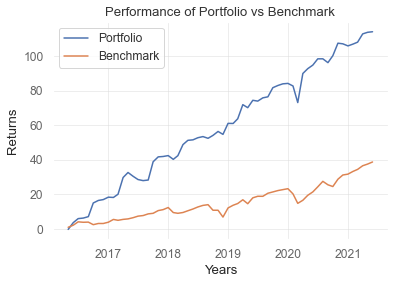

In [33]:
# Plot return of portfolio vs return of benchmark
plt.plot(df_portfReturn.iloc[:,0].cumsum()*100,label="Portfolio")
plt.plot(df_bm.iloc[:,-1].cumsum()*100,label="Benchmark")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("Performance of Portfolio vs Benchmark")
plt.show()

In [35]:
#Measure Beta and alpha
(beta, alpha) = stats.linregress(list(df_bm.iloc[:, -1]), list(df_portfReturn.iloc[:, 0].dropna()))[0:2]
print ("Beta:", round(beta, 2))
print ("Alpha:", round(alpha*12*100, 2))

Beta: 0.9
Alpha: 15.37


                           Strategy
-------------------------  ----------
Start Period               2016-05-01
End Period                 2021-05-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          197.5%
CAGR%                      23.91%

Sharpe                     7.78
Sortino                    20.83
Sortino/√2                 14.73

Max Drawdown               -10.97%
Longest DD Days            122
Volatility (ann.)          59.59%
Calmar                     2.18
Skew                       1.09
Kurtosis                   4.51

Expected Daily %           1.77%
Expected Monthly %         1.8%
Expected Yearly %          19.93%
Kelly Criterion            59.86%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.33%
Expected Shortfall (cVaR)  -4.33%

Gain/Pain Ratio            4.18
Gain/Pain (1M)             4.18

Payoff Ratio               1.8
Profit Factor              5.18
Common Sense Ratio         19.55
CPC Index              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-01,2020-03-01,2020-04-01,60,-10.966784,-1.492699
2,2017-06-01,2017-08-01,2017-10-01,122,-4.644317,-4.318914
3,2020-09-01,2020-09-01,2020-10-01,30,-2.218894,0.000000
4,2018-02-01,2018-02-01,2018-04-01,59,-2.174206,-0.082453
5,2019-05-01,2019-05-01,2019-06-01,31,-1.744313,0.000000


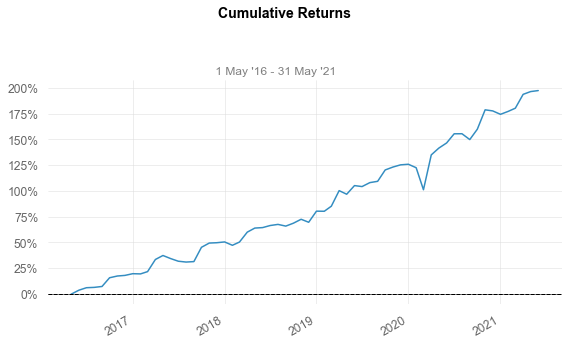

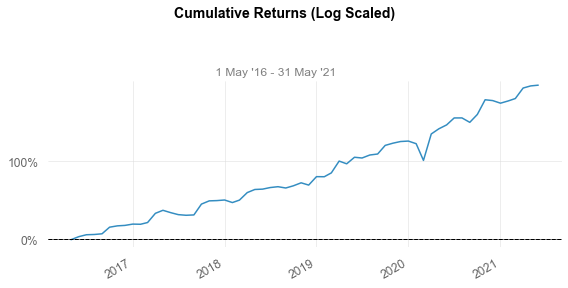

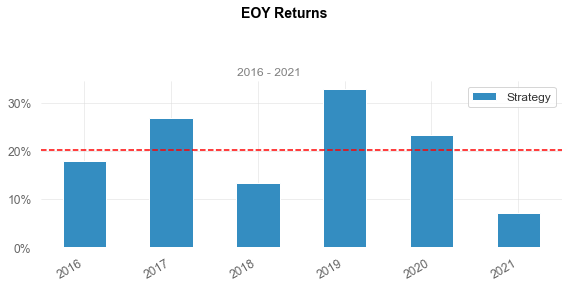

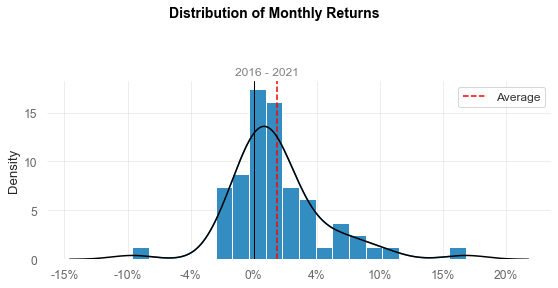

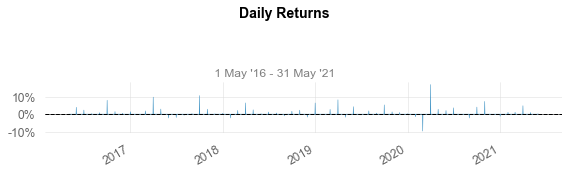

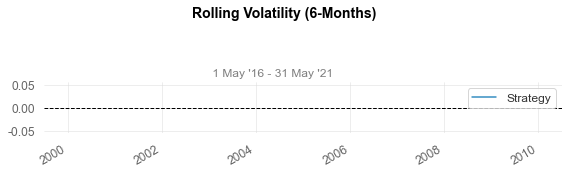

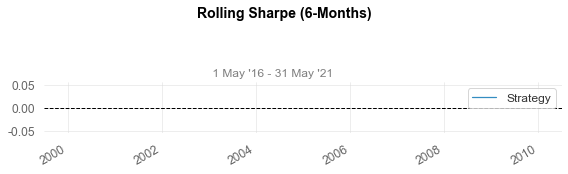

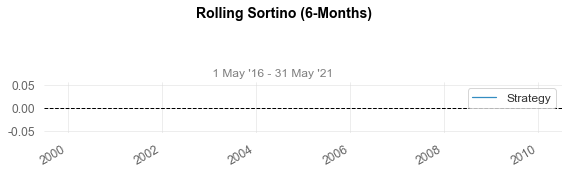

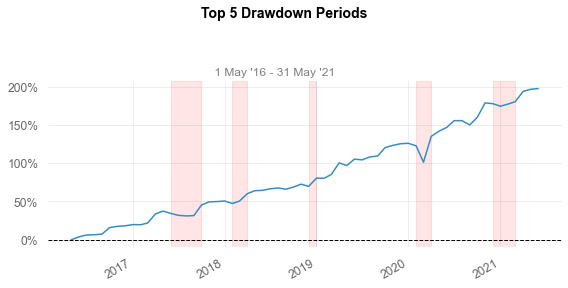

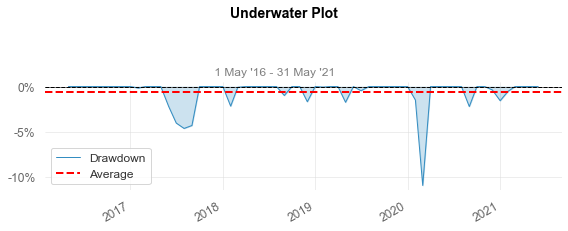

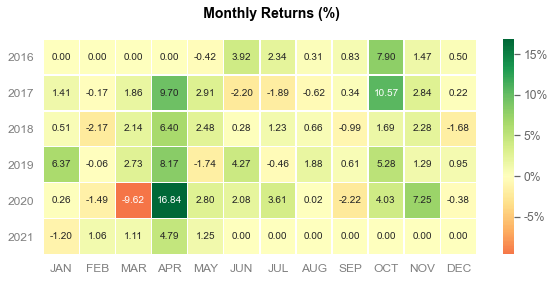

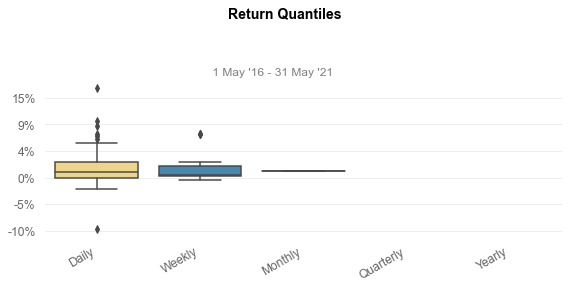

In [36]:
# Use quantstats to plot performance analysis - for reference
qs.reports.full(df_portfReturn.iloc[:, 0])

In [45]:
# Separate into different classes based on currencies, ESG or Non-ESG, and assets and get the corresponding weights
tickers_nonESG_equity_USD = ['XNTK', 'KCE', 'XLE', 'XLV', 'XLU']
tickers_nonESG_FI_USD = ['SHY', 'TLT', 'TIP', 'LQD', 'MHWIX']
tickers_nonESG_REIT_USD = ['IYR']
tickers_nonESG_Commodity_USD = [ 'GLD', 'GSG']
tickers_nonESG_equity_CAD = ['XIT.TO']
tickers_nonESG_FI_CAD = ['XBB.TO', 'XRB.TO']
tickers_nonESG_REIT_CAD = ['XRE.TO']
tickers_ESG_equity_USD = ['XLB', 'SOXX']

weights_asset_class = pd.DataFrame()
weights_asset_class["tickers_nonESG_equity_USD"] = weights[tickers_nonESG_equity_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_FI_USD"] = weights[tickers_nonESG_FI_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_REIT_USD"] = weights[tickers_nonESG_REIT_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_Commodity_USD"] = weights[tickers_nonESG_Commodity_USD].sum(axis=1)
weights_asset_class["tickers_nonESG_equity_CAD"] = weights[tickers_nonESG_equity_CAD].sum(axis=1)
weights_asset_class["tickers_nonESG_FI_CAD"] = weights[tickers_nonESG_FI_CAD].sum(axis=1)
weights_asset_class["tickers_nonESG_REIT_CAD"] = weights[tickers_nonESG_REIT_CAD].sum(axis=1)
weights_asset_class["tickers_ESG_equity_USD"] = weights[tickers_ESG_equity_USD].sum(axis=1)
weights_asset_class=weights_asset_class.set_index(testDate2)

AxesSubplot(0.125,0.2;0.775x0.68)


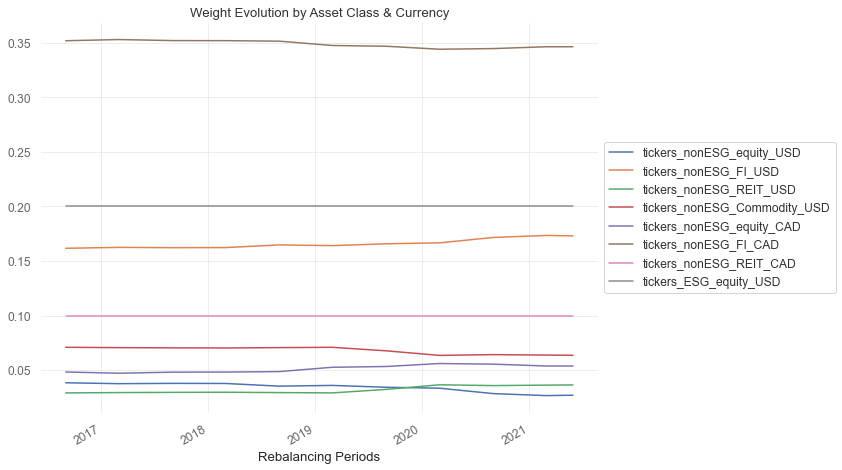

In [46]:
# Plot the weight evolution
x = weights_asset_class.plot.line(figsize=[10,8], title = "Weight Evolution by Asset Class & Currency", xlabel = "Rebalancing Periods")
x.legend(loc='center left', bbox_to_anchor=(1, 0.5))
print(x)

###################Return Attribution###################
                                  0
tickers_nonESG_equity_USD      2.13
tickers_nonESG_FI_USD         17.87
tickers_nonESG_REIT_USD        4.01
tickers_nonESG_Commodity_USD   5.99
tickers_nonESG_equity_CAD      5.65
tickers_nonESG_FI_CAD         34.35
tickers_nonESG_REIT_CAD       10.00
tickers_ESG_equity_USD        20.00


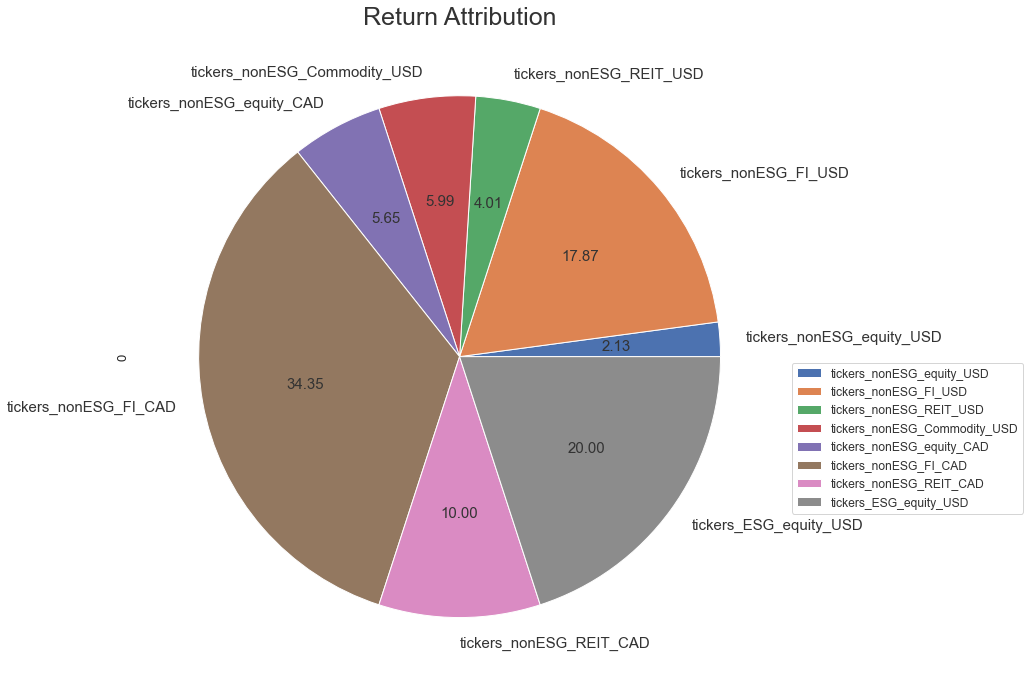

In [47]:
#Return Attribution
ret_contribution = (portfValue[-1]*weights.iloc[-1]-portfValue[0]*weights.iloc[0])/np.sum(portfValue[-1]*weights.iloc[-1]-portfValue[0]*weights.iloc[0])
ret_contribution = pd.DataFrame(ret_contribution).T
retc_asset_class = pd.DataFrame()
retc_asset_class["tickers_nonESG_equity_USD"] = ret_contribution[tickers_nonESG_equity_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_FI_USD"] = ret_contribution[tickers_nonESG_FI_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_REIT_USD"] = ret_contribution[tickers_nonESG_REIT_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_Commodity_USD"] = ret_contribution[tickers_nonESG_Commodity_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_equity_CAD"] = ret_contribution[tickers_nonESG_equity_CAD].sum(axis=1)
retc_asset_class["tickers_nonESG_FI_CAD"] = ret_contribution[tickers_nonESG_FI_CAD].sum(axis=1)
retc_asset_class["tickers_nonESG_REIT_CAD"] = ret_contribution[tickers_nonESG_REIT_CAD].sum(axis=1)
retc_asset_class["tickers_ESG_equity_USD"] = ret_contribution[tickers_ESG_equity_USD].sum(axis=1)

print ("###################Return Attribution###################")
returnAttribution = retc_asset_class.T
print (round(returnAttribution*100,2))
returnAttribution.plot.pie(autopct='%.2f',fontsize=15, figsize=(15, 12),subplots=True)
plt.title("Return Attribution",fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

###################Risk Attribution###################
                                  0
tickers_nonESG_equity_USD      3.48
tickers_nonESG_FI_USD          7.49
tickers_nonESG_REIT_USD        6.39
tickers_nonESG_Commodity_USD   6.46
tickers_nonESG_equity_CAD      8.34
tickers_nonESG_FI_CAD         14.37
tickers_nonESG_REIT_CAD       13.94
tickers_ESG_equity_USD        39.51


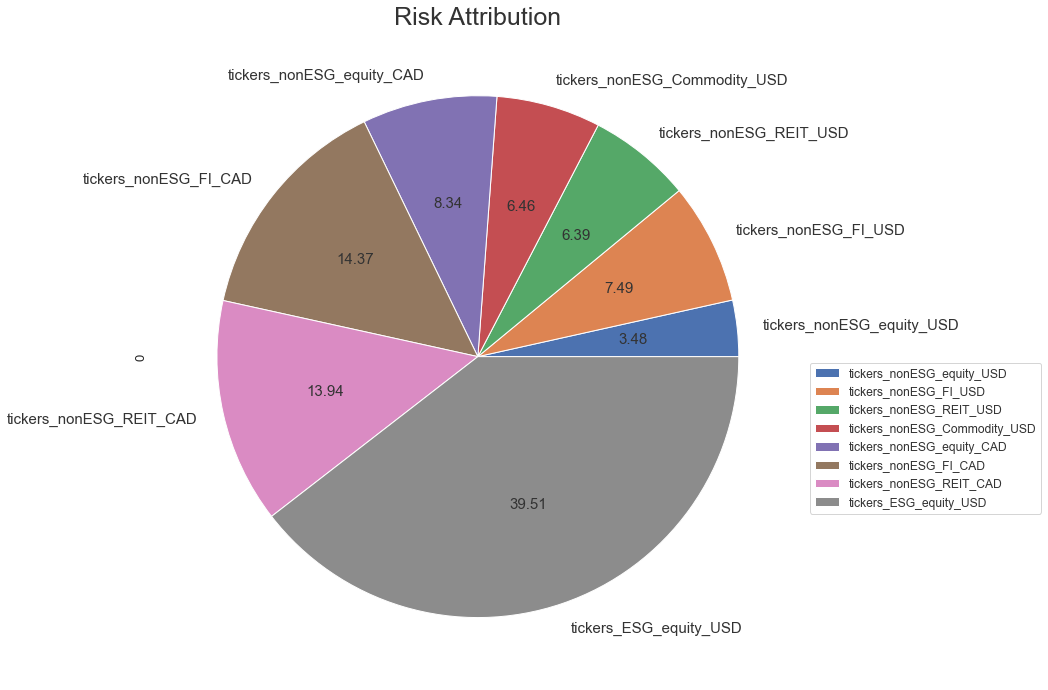

In [48]:
#Risk Attribution
price_portf_1y = price_portf.loc[testDate]
price_portf_1y = price_portf_1y.pct_change()
price_portf_1y = price_portf_1y.iloc[1:]
cov_matrix_1y = price_portf_1y.cov()
cov_matrix_1y_mtx = cov_matrix_1y.to_numpy()
latest_weight = weights.iloc[-1]
risk_contribution = calculate_risk_contribution(latest_weight, cov_matrix_1y_mtx)
risk_contribution = risk_contribution / np.sum(calculate_risk_contribution(latest_weight, cov_matrix_1y_mtx))
risk_contribution = pd.DataFrame(np.array(risk_contribution).T, columns = tickers)
rc_asset_class = pd.DataFrame()
rc_asset_class["tickers_nonESG_equity_USD"] = risk_contribution[tickers_nonESG_equity_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_FI_USD"] = risk_contribution[tickers_nonESG_FI_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_REIT_USD"] = risk_contribution[tickers_nonESG_REIT_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_Commodity_USD"] = risk_contribution[tickers_nonESG_Commodity_USD].sum(axis=1)
rc_asset_class["tickers_nonESG_equity_CAD"] = risk_contribution[tickers_nonESG_equity_CAD].sum(axis=1)
rc_asset_class["tickers_nonESG_FI_CAD"] = risk_contribution[tickers_nonESG_FI_CAD].sum(axis=1)
rc_asset_class["tickers_nonESG_REIT_CAD"] = risk_contribution[tickers_nonESG_REIT_CAD].sum(axis=1)
rc_asset_class["tickers_ESG_equity_USD"] = risk_contribution[tickers_ESG_equity_USD].sum(axis=1)

print ("###################Risk Attribution###################")
riskAttribution = rc_asset_class.T
print (round(riskAttribution*100,2))
riskAttribution.plot.pie(autopct='%.2f',fontsize=15, figsize=(15, 12),subplots=True)
plt.title("Risk Attribution",fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()